In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

In [3]:
def _calculate_kappa(k1, k2, psi):
    """
    Calculate kappa from k1 and k2
    """
    return np.sqrt(2 * ((k1 * np.cos(psi))**2 + (k2 * np.sin(psi))**2))

In [4]:
"""
The equations from this point on reference the simulation paper.
"""

def E_kappa(kappa: float, L2D: float, c: float) -> float:
    """
    Calculates the energy spectrum in terms of kappa = sqrt(2(k1^2cos^2psi + k2^2sin^2psi))
    """
    numerator = c * (kappa**3)
    denominator = (L2D**(-2) + kappa**2)**(7/3)

    return numerator / denominator

def E_kappa_attenuated(kappa: float, L2D: float, z_i: float, c: float) -> float:
    """
    Attenuated energy spectrum in terms of kappa
    """
    return E_kappa(kappa, L2D, c) / (1 + (kappa * z_i)**2)

In [10]:
def __spectral_tensor_common(kappa: float, L2D: float, z_i: float, c: float, k: float, use_k: bool = False) -> float:
    """
    Common leading factor for each spectral tensor component
    """
    energy = E_kappa_attenuated(kappa, L2D, z_i, c)

    denom = (np.pi * kappa) if not use_k else (np.pi * k)

    return energy / denom

def __spectral_tensor_unattenuated_common(kappa: float, L2D: float, c: float, k: float, use_k: bool = False) -> float:
    """
    Common leading factor for each spectral tensor component

    This is for the unattenuated energy spectrum
    """

    return E_kappa(kappa, L2D, c) / (np.pi * k)

def sim_spectral_tensor_11(
    k1: float,
    k2: float,
    L2D: float,
    z_i: float,
    c: float,
    psi: float,
    attenuated: bool = True,
    use_k: bool = False
) -> float:
    """
    Simulated spectral tensor with energy spectrum in kappa

    Use attenuated to control attenuation/not

    This is for the 11 component
    """
    kappa = _calculate_kappa(k1, k2, psi)
    k = np.sqrt(k1**2 + k2**2)

    leading_factor = __spectral_tensor_common(
        kappa, L2D, z_i, c, k, use_k
    ) if attenuated else __spectral_tensor_unattenuated_common(
        kappa, L2D, c, k, use_k
    )

    projection = 1 - (k1 / k)**2

    return leading_factor * projection


def sim_spectral_tensor_22(
    k1: float, 
    k2: float, 
    L2D: float, 
    z_i: float, 
    c: float, 
    psi: float, 
    attenuated: bool = True,
    use_k: bool = False
) -> float:
    """
    Simulated spectral tensor with energy spectrum in kappa

    Use attenuated to control attenuation/not

    This is for the 22 component
    """
    kappa = _calculate_kappa(k1, k2, psi)
    k = np.sqrt(k1**2 + k2**2)

    leading_factor = __spectral_tensor_common(kappa, L2D, z_i, c, k, use_k) if attenuated else __spectral_tensor_unattenuated_common(kappa, L2D, c, psi)

    projection = 1 - (k2 / k)**2

    return leading_factor * projection

In [11]:
import warnings


def eq6_numerical_F11_2D(
    k1: float,
    psi: float,
    L2D: float,
    z_i: float,
    c: float,
    attenuated: bool = True,
    use_k: bool = True
):
    """
    Implements equation 6 to obtain F11
    """

    res, err = integrate.quad(
        lambda k2: sim_spectral_tensor_11(k1, k2, L2D, z_i, c, psi, attenuated, use_k),
        -np.inf, np.inf,
    )
    
    return res, err

def eq6_numerical_F22_2D(
    k1: float,
    psi: float,
    L2D: float,
    z_i: float,
    c: float,
    attenuated: bool = True,
    use_k: bool = True
):
    """
    Implements equation 6 to obtain F22
    """

    res, err = integrate.quad(
        lambda k2: sim_spectral_tensor_22(k1, k2, L2D, z_i, c, psi, attenuated, use_k),
        -np.inf, np.inf,
    )

    return res, err

Average error with attenuation: 0.0000000000
Average error without attenuation: 0.0000000131
Max error with attenuation: 0.0000000000
Max error without attenuation: 0.0000000131
L2 norm with attenuation: 0.0000000000
L2 norm without attenuation: 0.0000000131


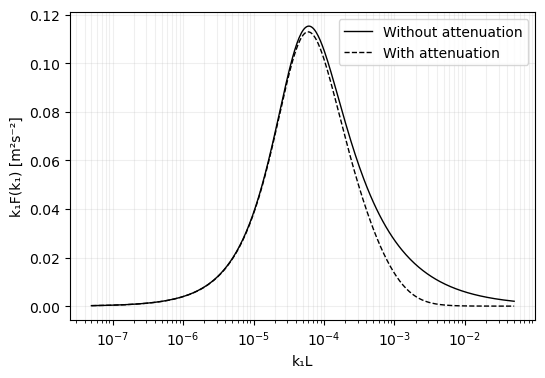

In [ ]:
"""
This cell aims to recreate Figure 1 in the theory paper.
"""

plt.clf(); plt.close('all');

L2D = 20_000 # km
z_i = 500 # m
psi = np.deg2rad(43)

c = 1e-3

k1 = np.logspace(-3, 3, 400) / L2D

############################################
# Collect the two arrays and resp errors

atten_err_list = []
unatten_err_list = []

numerical_F11_attenuated = []
numerical_F11_unattenuated = []

for _k1 in k1:
    atten_res, atten_err = eq6_numerical_F11_2D(_k1, psi, L2D, z_i, c, attenuated=True)
    unatten_res, unatten_err = eq6_numerical_F11_2D(_k1, psi, L2D, z_i, c, attenuated=False)

    atten_err_list.append(atten_err)
    unatten_err_list.append(unatten_err)

    numerical_F11_attenuated.append(_k1 * atten_res)
    numerical_F11_unattenuated.append(_k1 * unatten_res)

############################################
# Print some basic stats for the integration errors

print(f"Average error with attenuation: {np.mean(atten_err):.10f}")
print(f"Average error without attenuation: {np.mean(unatten_err):.10f}")

print(f"Max error with attenuation: {np.max(atten_err):.10f}")
print(f"Max error without attenuation: {np.max(unatten_err):.10f}")

print(f"L2 norm with attenuation: {np.linalg.norm(atten_err):.10f}")
print(f"L2 norm without attenuation: {np.linalg.norm(unatten_err):.10f}")

############################################
# Plot

plt.figure(figsize=(6, 4))

plt.plot(k1 * L2D, numerical_F11_unattenuated, "-", color="black", label="Without attenuation", linewidth=1)
plt.plot(k1 * L2D, numerical_F11_attenuated, "--", color="black", label="With attenuation", linewidth=1)
plt.xscale("log")
plt.xlabel("k₁L")
plt.ylabel("k₁F(k₁) [m²s⁻²]")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

In [15]:
import numba

In [31]:
class generator:
    def __init__(self, config):
        # Physical parameters
        self.sigma2 = config["sigma2"]
        self.L_2d = config["L_2d"]
        self.psi = config["psi"]
        self.z_i = config["z_i"]

        self.L1 = config["L1_factor"] * self.L_2d
        self.L2 = config["L2_factor"] * self.L_2d

        self.N1 = 2 ** config["N1"]
        self.N2 = 2 ** config["N2"]

        self.dx = self.L1 / self.N1
        self.dy = self.L2 / self.N2

        x = np.linspace(0, self.L1, self.N1, endpoint=False)
        y = np.linspace(0, self.L2, self.N2, endpoint=False)
        self.X, self.Y = np.meshgrid(x, y, indexing="ij")

        self.k1_fft = 2 * np.pi * np.fft.fftfreq(self.N1, self.dx)
        self.k2_fft = 2 * np.pi * np.fft.fftfreq(self.N2, self.dy)
        self.k1, self.k2 = np.meshgrid(self.k1_fft, self.k2_fft, indexing="ij")


        self.k_mag = np.sqrt(self.k1**2 + self.k2**2)

        self.k1L = self.k1 * self.L_2d
        self.k2L = self.k2 * self.L_2d
        self.kL = self.k_mag * self.L_2d

    # ------------------------------------------------------------------------------------------------ #

    # TODO: This assumes isotropic, so we need to add kappa back in
    @staticmethod
    @numba.njit(parallel=True)
    def _generate_numba_helper(
        k1: np.ndarray,
        k2: np.ndarray,
        c: float,
        L_2d: float,
        psi: float,
        z_i: float,
        N1: int,
        N2: int,
        noise_hat: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray]:
        k_mag = np.sqrt(k1**2 + k2**2)
        kappa = np.sqrt(2 * ((k1 * np.cos(psi))**2 + (k2 * np.sin(psi))**2))

        phi_ = np.empty_like(k_mag)
        for i in numba.prange(N1):
            for j in numba.prange(N2):
                _kappa: float
                if kappa[i, j] < 1e-10:
                    _kappa = 1e-10
                else:
                    _kappa = kappa[i, j]

                _k: float
                if k_mag[i, j] < 1e-10:
                    _k = 1e-10
                else:
                    _k = k_mag[i, j]

                energy = c * _kappa**3 / (
                    ((L_2d**-2 + _kappa**2) ** 7/3 ) * (1 + _kappa**2 * z_i**2)
                )

                phi_[i,j] = np.sqrt(
                    energy / (np.pi * _k**3)
                )

        C1 = 1j * phi_ * k2
        C2 = 1j * phi_ * (-1 * k1)

        return C1 * noise_hat, C2 * noise_hat

    def generate(self, eta_ones=False):
        # TODO: Numba numba numba!

        # Calculate scaling constant c
        self.c = (8.0 * self.sigma2) / (9.0 * (self.L_2d ** (2 / 3)))

        # Random noise
        noise_hat: np.ndarray
        if eta_ones:
            noise_hat = np.ones_like(self.k1, dtype=complex)
        else:
            noise = np.random.normal(0, 1, size=(self.N1, self.N2))
            noise_hat = np.fft.fft2(noise)
        
        # Fourier space
        u1_freq, u2_freq = self._generate_numba_helper(
            self.k1,
            self.k2,
            self.c,
            self.L_2d,
            self.psi,
            self.z_i,
            self.N1,
            self.N2,
            noise_hat
        )

        transform = 1 if eta_ones else np.sqrt(self.dx * self.dy)

        u1 = np.real(np.fft.ifft2(u1_freq) / transform)
        u2 = np.real(np.fft.ifft2(u2_freq) / transform)

        self.u1 = u1
        self.u2 = u2

        return u1, u2

    # ------------------------------------------------------------------------------------------------ #

    @staticmethod
    @numba.njit(parallel=True)
    def _compute_spectrum_numba_helper(
        k1_flat: np.ndarray,
        k1_pos: np.ndarray,
        power_u1_flat: np.ndarray,
        power_u2_flat: np.ndarray,
        L2: float,
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Numba-accelerated helper function for the estimation
        of the 1d spectra F_11 and F_22.
        """

        F11 = np.empty_like(k1_pos)
        F22 = np.empty_like(k1_pos)

        dk2 = 2 * np.pi / L2

        for i in numba.prange(len(k1_pos)):
            k1_val = k1_pos[i]
            indices = np.where(k1_flat == k1_val)[0]

            if len(indices) > 0:
                F11[i] = np.sum(power_u1_flat[indices]) * dk2
                F22[i] = np.sum(power_u2_flat[indices]) * dk2

        return F11, F22

    def compute_spectrum(
        self
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Estimates the 1d spectra F11 and F22 of the velocity fields u1 and u2"""

        u1_fft = np.fft.fft2(self.u1)
        u2_fft = np.fft.fft2(self.u2)

        k1_pos = np.abs(self.k1_fft)
        k1_pos = k1_pos[np.argsort(k1_pos)]
        k1_pos = k1_pos[1:-1]

        power_u1 = (np.abs(u1_fft)) ** 2
        power_u2 = (np.abs(u2_fft)) ** 2

        if np.isnan(power_u1).any() or np.isnan(power_u2).any():
            import warnings
            warnings.warn("NaN detected in power spectra!")

        k1_flat = self.k1.flatten()
        power_u1_flat = power_u1.flatten()
        power_u2_flat = power_u2.flatten()

        F11, F22 = self._compute_spectrum_numba_helper(
            k1_flat,
            k1_pos, 
            power_u1_flat, 
            power_u2_flat, 
            self.L2
        )

        return k1_pos, F11, F22

In [32]:
config_a = {
    "L1_factor": 40,
    "L2_factor": 5,
    "N1": 10,
    "N2": 10,
    
    "L_2d": 15_000.0,
    "sigma2": 2.0,
    "psi": np.deg2rad(45),
    "z_i": 500,
}

gen_a = generator(config_a)

In [33]:
config_b = {
    "L1_factor": 1,
    "L2_factor": 0.125,
    "N1": 10,
    "N2": 10,
    
    "L_2d": 15_000.0,
    "sigma2": 2.0,
    "psi": np.deg2rad(45),
    "z_i": 500,
}

gen_b = generator(config_b)

Average error for (a) F11: 0.0000154762
Average error for (a) F22: 153.2881011141
Max error for (a) F11: 0.0001365742
Max error for (a) F22: 5053.0830650185
L2 norm for (a) F11: 0.0007123442
L2 norm for (a) F22: 13920.9918304961


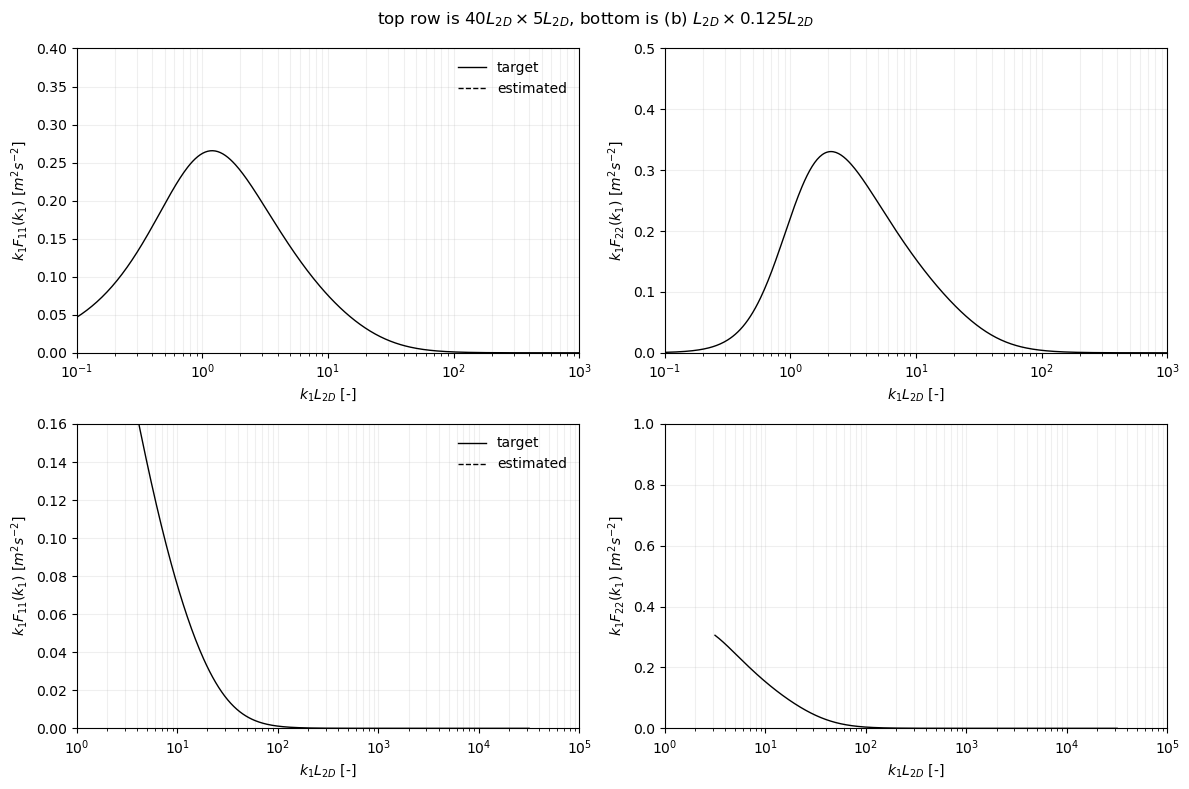

In [35]:
plt.clf(); plt.close('all');

# Parameters
L2D = 20_000 # m
sigma2 = 2 # (m/s)^2
z_i = 500 # m
psi = np.deg2rad(45)

c = (8 * sigma2) / (9 * (L2D**(2/3)))

warnings.filterwarnings("ignore")

########################################################################
# Domain setup


# grab subplots, then helper for subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

def setup_subplots(ax, ylim, is_F11 = True, is_a = True):
    ax.set_xscale("log")
    ax.grid(True, which="both", linestyle="-", alpha=0.2)
    ax.set_xlabel("$k_1 L_{2D}$ [-]")
    ax.set_ylabel("$k_1 F(k_1)$ [m²s⁻²]")

    if is_F11:
        ax.set_ylabel("$k_1 F_{11}(k_1)$ $[m^2s^{-2}]$")
    else:
        ax.set_ylabel("$k_1 F_{22}(k_1)$ $[m^2s^{-2}]$")

    if is_a:
        ax.set_xlim(1e-1, 1e3)
    else:
        ax.set_xlim(1e0, 1e5)

    ax.set_ylim(0, ylim)

#######################################################################
# (a) Top plots - 40L2D x 4L2D domain

k1_arr_a = np.logspace(-1, 3, 400) / L2D


# Collect the arrays
numerical_F11_a = []
numerical_F22_a = []

numerical_F11_err_a = []
numerical_F22_err_a = []

for k1 in k1_arr_a:
    f11_res, f11_err = eq6_numerical_F11_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)
    f22_res, f22_err = eq6_numerical_F22_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)

    numerical_F11_a.append(k1 * f11_res)
    numerical_F22_a.append(k1 * f22_res)

    numerical_F11_err_a.append(f11_err)
    numerical_F22_err_a.append(f22_err)


# Print error stats
print(f"Average error for (a) F11: {np.mean(numerical_F11_err_a):.10f}")
print(f"Average error for (a) F22: {np.mean(numerical_F22_err_a):.10f}")

print(f"Max error for (a) F11: {np.max(numerical_F11_err_a):.10f}")
print(f"Max error for (a) F22: {np.max(numerical_F22_err_a):.10f}")

print(f"L2 norm for (a) F11: {np.linalg.norm(numerical_F11_err_a):.10f}")
print(f"L2 norm for (a) F22: {np.linalg.norm(numerical_F22_err_a):.10f}")


gen_a.generate()
k1_pos, F11_est, F22_est = gen_a.compute_spectrum()


ax1.plot(k1_arr_a * L2D, numerical_F11_a, "-", color="black", label="target", linewidth=1)
ax1.plot(k1_pos * L2D, k1_pos * F11_est, "--", color="black", label="estimated", linewidth=1)
setup_subplots(ax1, 0.4, is_F11=True, is_a=True)
ax1.legend(frameon=False)

ax2.plot(k1_arr_a * L2D, numerical_F22_a, "-", color="black", label="target", linewidth=1)
ax2.plot(k1_pos * L2D, k1_pos * F22_est, "--", color="black", label="estimated", linewidth=1)
setup_subplots(ax2, 0.5, is_F11=False, is_a=True)

#######################################################################
# (b) Bottom plots - L2D x 0.125L2D domain

k1_arr_b = np.logspace(0.5, 4.5, 400) / L2D
numerical_F11_b = []
numerical_F22_b = []

for k1 in k1_arr_b:
    f11_res, _ = eq6_numerical_F11_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)
    f22_res, _ = eq6_numerical_F22_2D(k1, psi, L2D, z_i, c, attenuated=True, use_k=True)

    numerical_F11_b.append(k1 * f11_res)
    numerical_F22_b.append(k1 * f22_res)

gen_b.generate()
k1_pos, F11_est, F22_est = gen_b.compute_spectrum()

ax3.plot(k1_arr_b * L2D, numerical_F11_b, "-", color="black", label="target", linewidth=1)
ax3.plot(k1_pos * L2D, k1_pos * F11_est, "--", color="black", label="estimated", linewidth=1)
setup_subplots(ax3, 0.16, is_F11=True, is_a=False)
ax3.legend(frameon=False)

ax4.plot(k1_arr_b * L2D, numerical_F22_b, "-", color="black", label="target", linewidth=1)
ax4.plot(k1_pos * L2D, k1_pos * F22_est, "--", color="black", label="estimated", linewidth=1)
setup_subplots(ax4, 1.0, is_F11=False, is_a=False)

#########################################################################
# Overall plot edits
fig.suptitle(r"top row is $40L_{2D}\times 5L_{2D}$, bottom is (b) $L_{2D} \times 0.125L_{2D}$", y=0.98)
plt.tight_layout()
plt.show()

warnings.filterwarnings("default")


(array([1.04719755e-05, 1.04719755e-05, 2.09439510e-05, ...,
        5.34070751e-03, 5.35117949e-03, 5.35117949e-03]),
 array([1.40288672e+05, 1.40288672e+05, 1.35531836e+05, ...,
        5.43040323e+00, 4.91329058e+00, 4.91329058e+00]),
 array([9.35653999e+03, 9.35653999e+03, 4.06322350e+04, ...,
        2.02905427e+01, 2.01603411e+01, 2.01603411e+01]))